<a href="https://colab.research.google.com/github/marekpiotradamczyk/ml_uwr_22/blob/main/Lectures/07-notes_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning @ UWr 2023

**Lecture 05**

In the previous lecture we have seen a linear regression model which approximates the dataset, and hence makes the predictions, based on the assumption that it's somehow close in it's shape to a line. This model was used for regression problems, i.e., when we wanted to predict numerical values.

In this lecture we are going to turn back to classification problems. But as in the linear regression, we are going to assume that the data is (or approximately is) linearly separable.

We will also revisit Linear Regression, taking a closer look at its loss function and understanding what tradeoffs we can make.

## Logistic Regression for Irises

Lets get back to our Iris classification problem: preidct the flower species, based on `petal length` and `petal width` features (we limit ourselves to 2 dimesions to be able to plot what is happening).

Let's first load the data!

In [1]:
!pip install httpimport


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import sys

import numpy as np
import pandas as pd

import scipy.stats as sstats

from sklearn import datasets
import sklearn.linear_model

from matplotlib import animation, pyplot, rc
import matplotlib.pyplot as plt
import seaborn as sns

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments'):
     from common.plotting import plot_mat

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

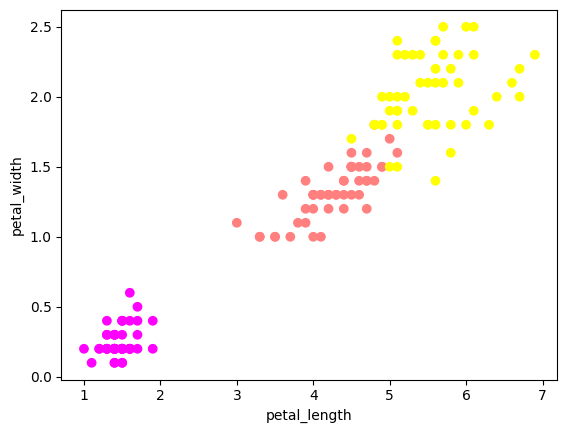

In [3]:
iris = datasets.load_iris()
print("Features: ", iris.feature_names)
print("Targets: ", iris.target_names)
petal_length = iris.data[:, iris.feature_names.index("petal length (cm)")].reshape(-1, 1)
petal_width = iris.data[:, iris.feature_names.index("petal width (cm)")].reshape(-1, 1)


plt.scatter(petal_length, petal_width, c=iris.target, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

We will first simplify our task and consider binary classification: tell Versicilors from Virginicas.

Only then, we will see how to generalize our approach to more classes.

### Logistic Regressoin intuitions

Looking at the Iris scaterplot, we intuitively see that we could draw a line which approximately separates the Versicolors from Virginicas. While it will not correctly classify all flowers near the boundary region, it will do a decent job for the more distant ones.

One such guesstimated line may be $6.5 - \text{petal length} - \text{petal width}=0$.

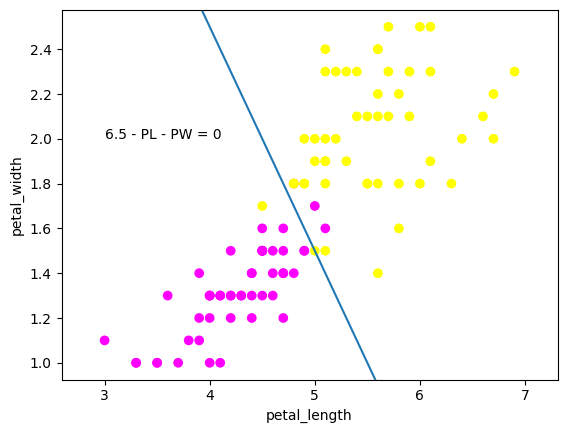

In [4]:
# Extract the petal_length and petal_width of versicolors and virginicas
IrisX = np.hstack([np.ones_like(petal_length), petal_length, petal_width])
IrisX = IrisX[iris.target != 0, :]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target != 0] - 1).reshape(-1, 1).astype(np.float64)

plt.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
ylim = plt.ylim()

# Guesstimate a separation boundary
plt.plot(plt.xlim(), 6.5 - np.array(plt.xlim()))
plt.ylim(*ylim)
_ = plt.text(3,2,"6.5 - PL - PW = 0")

### Why not regress features directly onto probabilities

How can we obtain this separating line?

One posible solution would be to simply treat the binary class identifier as a numerical value, and fit a linear regression model, hpoing that it will output a number close to 0 for one class and close to 1 for the other class. 

However, this simplified approach has certain disadvantages. For instance, how do we interpret an output of 2? Is the model extremely confident about its output? 

Moreover, the least squares criterion doesn't make much sense: for instance, when $y=1$, it penalizes an output of 2 in the same way as an noutput of 0 (the distance from the target 1 is the same in both cases)!

### Regression with a squasing function

Getting back to classification problem, we want to model the conditional probability 
$$
p(\text{class}|\text{petal length}, \text{petal width}) = p(y|x)
$$

This conditioanl probability should depend on the distance of a point to the separating boundary. Points near the separating line are ambiguous - probablity there should be close to 0.5. On the other hand, the model should be failry certain on points far away from the separating boundary.

We thus need to squash the distance from the boundary to the $0-1$ range of valid probabilities. We will accomplish this by mapping the distance through a "sigmoid" (meaning S-shaped function). A very popular function is the logistic sigmoid:
$$
\sigma(z) = \frac{1}{1+e^{-z}}
$$

Let's see how it looks like.

Text(0.5, 1.0, 'The logistic sigmoid function')

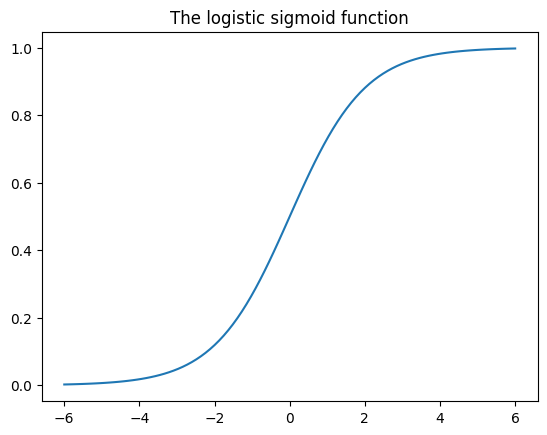

In [5]:
z = np.linspace(-6,6,100)
plt.plot(z, 1/(1+np.exp(-z)))
plt.title('The logistic sigmoid function')

### Properties of the logistic sigmoid

The logistic sigmoif has a few nice properties:

1. $\sigma(0) = 0.5$. This means that points exaclt on the separating line are ambigous, just like we desired.
2. $\lim_{z\rightarrow \infty} \sigma(z) = 1$ and $\lim_{z\rightarrow -\infty} \sigma(z) = 0$: the further we are from the separating boundary, the more confident the model.
3. $\sigma(-z) = 1 - \sigma(z)$. The function is symmetrical, it doesn't matter which class we treat as the "positive" one.

### Definition of the Logistic Regression model

Armed with the $\sigma$ squashing function, let's define:

$$
p(y=1|x;\Theta) = \sigma(x\Theta),
$$
where $x$ is a row vector of features $y$ is a random variable denoting the target class and $\Theta$ is a column vector of model parameters.

### Logistic regression loss function

To fit parameters $\Theta$, 
we will again use the Maximum Likelihood principle. Please observe that:

$$
\begin{align}
p(y=y^{(i)}|x^{(i)};\Theta) &= \cases{p(y=1|x;\Theta) &if $y^{(i)}=1$ \\ 1-p(y=1|x^{(i)};\Theta) &if $y^{(i)}=0$} \\
&= p(y=1|x^{(i)};\Theta)^{y^{(i)}}(1-p(y=1|x^{(i)};\Theta))^{(1-y^{(i)})} \\
&= \sigma(x^{(i)}\Theta)^{y^{(i)}}(1-\sigma(x^{(i)}\Theta))^{(1-y^{(i)})}
\end{align}
$$

Therefore the negative log likelihood ($nll$) is:
$$
\begin{split}
nll(\Theta) &= -\sum_{i=1}^{N} y^{(i)} \log \sigma(x^{(i)}\Theta) + (1-y^{(i)})\log(1-\sigma(x^{(i)}\Theta)) = \\
&= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta)
\end{split}
$$

This loss function is often referred to as the *cross-entropy* loss.


## Logistic regression training

We now need to find the $\Theta$ which minimizes the likelihood function. Again, we will use calculus and compute the gradient of the nll. We will do it in steps. First please observe how simple is the gradient of the logistic sigmoid function:

$$ \frac{\partial}{\partial z}\sigma(z) = \sigma(z)(1-\sigma(z))$$

Now let $z^{(i)} = x^{(i)}\Theta$. First lets compute the gradient of the loss on a single sample $nll^{(i)}$:

$$
\frac{\partial nll^{(i)}(\Theta)}{\partial \Theta} = \frac{\partial nll^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta}
$$

The derivative of the first term on the right hand turns out to be very simple:

$$
\begin{align}
\frac{\partial nll^{(i)}}{\partial z^{(i)}} &= \frac{\partial -\left(y^{(i)} \log \sigma(z^{(i)}) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))\right)}{\partial z^{(i)}} \\
&= -y^{(i)}\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{\sigma(z^{(i)})} + 
(1-y^{(i)})\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{1-\sigma(z^{(i)})} \\
&= -y^{(i)}(1-\sigma(z^{(i)})) + (1-y^{(i)})\sigma(z^{(i)})\\
&=\sigma(z^{(i)})-y^{(i)}
\end{align}
$$

The second term $\frac{\partial z^{(i)}}{\partial\Theta}$ is also easy:

$$
\frac{\partial z^{(i)}}{\partial\Theta} = \frac{\partial x^{(i)}\Theta}{\partial\Theta} = (x^{(i)})^T
$$

Taken together the loss derivative is:

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = \sum_{i=1}^{N}\frac{\partial nll^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta} = \sum_{i=1}^{N}(x^{(i)})^T\left(\sigma(z^{(i)})-y^{(i)}\right)
$$

The expression can be further simplified by using the data matrix $X$ (of shape $N\times D$ whose $i$-th row is the $i$-th sample), the target matrix $Y$, letting $Z=X\Theta$, and assuming that the function $\sigma()$ is applied separately to all elements of its input.

$$
\frac{\partial nll(\Theta)}{\partial \Theta} = X^T\left(\sigma(Z)-Y\right)
$$

#### Comparison of gradients of Linear and Logistic Regression

Recall from Lecture 2, that the linear regression gradient we have derived was proportional to
$$
X^T(X\Theta - Y) = X^T E
$$
where just like for logistic regression $X$ is the $X\times D$ data matrix, $Y$ is the $X\times 1$ coliumn vector of targets, and $E$ is the column vector of errors.

Notice, that for Logistic regression the gradient takes essentially the same form:

$$
X^T\left(\sigma(X\Theta) - Y\right) = X^T E'
$$

where $E'$ is the "error" of logistic regression - the difference betweenn the desired target, encoed as $0$ or $1$ and the probability assigned by the model.

This is not a coincidence. Linear and Logistic regresison belong to the family of [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model), which contains many more regression-like models.

Unfortunately, the gradient of the loss is no longer linear with $\Theta$. No closed-form solution exists. Therefore we will search for the minimum of the loss function by taking small steps along the gradient of the loss. We will call this the **gradient descent**.

### The Gradient Descent algorithm

Due to the nonlinear $\sigma$ function appearing in the gradient of neg-log likelihood for logistic regression, we can't derive a closed form formula for the zero-crossing of the gradient.

Instead we will follow an iterative minimization procedure. Recall that the negated gradient of a function points in the direction of the maximal function decrease (in fact, one can define the gradient to be direction of maximum function increase for an inifitesimally small step).

Our approach to solving the linear regression problem will follow this intuition: we will evaluate the neg-log likelihood, take its gradient, then make a small step against the gradient, hopefully getting a smaller neg-log likelihood value. After many such steps we hope to get to a local minimum - a point where the gradient is zero, and we can't go any lower.

It turns out, that again our optimization problem is convex, and the local minimum reached with gradient descent will be the global one.

The gradient descent algorithm is very simple:

* $\Theta \gets $ a sane initial value
* `While` not converged:
    * 
$\Theta \gets \Theta - \alpha \frac{\partial L(\Theta)}{\partial\Theta}$

When GD converges, gradient is close to zero and neg-log likelihood stops to change. 


#### We will now see a demonstration of GD solving the logistic regression on Irises

Please note, that unlike previous lectures, the details of the implementation are missing: you will implement logistic regression during the programming assignment!

In [6]:


def GD(f, Theta0, alpha, stop_tolerance=1e-10, max_steps=100000):
    history = [Theta0]

    Theta = Theta0
    value = np.inf

    step = 0
    while step < max_steps:
        previous_value = value
        value, gradient = f(Theta)
        # print value
        if np.abs(value-previous_value) < stop_tolerance:
            break

        Theta = Theta - alpha * gradient
        history.append(Theta)
        step += 1
    return Theta, history


class LogisticRegressionCost(object):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    # note: this creates a Pyton callable - i.e. an abject that can be called
    # as a function
    def __call__(self, Theta):
        X = self.X
        Y = self.Y
        ThetaR = Theta.reshape(X.shape[1], 1)
        h = 1.0 / (1.0 + np.exp(-X @ ThetaR))
        nll = -(Y.T @ np.log(h) + (1 - Y.T) @ np.log(1.0 - h))[0]
        grad = -X.T @ (Y - h)
        return nll, grad.reshape(Theta.shape)


def logreg(X, Y, Theta0=None, **kwargs):
    LR = LogisticRegressionCost(X, Y)
    if Theta0 is None:
        Theta0 = np.zeros((X.shape[1],))
    ThetaOpt, history = GD(LR, Theta0=Theta0,  **kwargs)
    # import scipy.optimize as sopt
    # rrr = sopt.fmin_l_bfgs_b(LR, Theta0, iprint=1)[0]
    # return rrr, []
    return ThetaOpt, history


In [7]:
#note: the step-size needs to be tuned!
ThetaOpt, history = logreg(IrisX, IrisY, alpha=1e-2, stop_tolerance=1e-8, max_steps=100000)
print(f"Gradient descent made {len(history)} steps")
print("Theta is: ", ThetaOpt)

Gradient descent made 81528 steps
Theta is:  [-45.08388493   5.726315    10.4161067 ]


In [8]:
# Make an animation of training

fig = plt.figure()
ax = plt.axes()
ax.scatter(IrisX[:, 1], IrisX[:, 2], c=IrisY, cmap="spring")
plt.xlabel("petal_length")
plt.ylabel("petal_width")

xlim = np.array(plt.xlim())
ylim = plt.ylim()

line, = plt.plot([],[])

plt.close()

def init():
    line.set_data([], [])
    return line,

def animate(i):
    epoch = 1 + int(1.0 * (len(history)-1) / num_frames * i)
    Theta = history[epoch]
    ax.set_title('Epoch %d, Theta: %s' % (epoch, Theta,))
    yy = (Theta[0] + xlim * Theta[1]) / - Theta[2]
    line.set_data(xlim, yy)
    return line,

num_frames=100
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=30, blit=True)
rc('animation', html='jshtml')
anim

The animation shows how logistic regression iteratively moves the separating line towards its final location.

#### Softmax Regression - dealing with multiple classes

We will now generalize Linear Regression to handle many classes.

The model will produce a probability distribution over the $k$ classes: it will have $k$ outputs, each corresponding to the probability of one class. The outputs will be constrained ot sume to one.

Intuitively, the model will first compute a score for each class. The scores are independent, each score is computed using a linear projection of the features:

$$
z_k = x\Theta_k,
$$

where $z_k$ is the score for class $k$ and $\Theta_k$ is the **vector** of scoring parameters for the $k$-th class.

We can egain use matrix algebra and drop the indices:
$$
z = x\Theta
$$
with $z\in\mathbb{R}^{1\times k}$ is the vector of scores, $x\in 1\times D$ is the vector with a sample's fetures and $\Theta\in{D\times k}$ is the **matrix** of all paramaters.

We will normalize the sores using the SoftMax function:

$$
\text{SoftMax}(z)_j = \frac{e^{z_j}}{\sum_k e^{z_k}}
$$

Please note, that SoftMax works on all the scores at once, it is not an elementwise function. In particular, the output for one class depends on all other ones, beacuse they are jointly normalized to sum to 1.

Thus SoftMax regression learns the function

$$
h(x, \Theta) = \text{SoftMax}(x\Theta).
$$

And we interpret the model's outputs as probabilities:

$$
p(y=k|x;\Theta) = h(x, \Theta)_k = \text{SoftMax}(x\Theta)_k.
$$

Application of the MLE principle yields the cross-entropy loss, which is analogous to the one for linear regression:

$$
J(\Theta) = -\sum_{i=1}^N\sum_k[y^{(i)}=k]\log \left(h(x^{(i)}, \Theta)_k\right)
$$

where $[y^{(i)}=k]$ is an indicator function which takes value 1 if $y^{(i)}=k$ and 0 otherwise.

SoftMax regression is a generalization of logistic regression, which we will show in a homework assignment.